In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Часть 1. Приоритизация гипотез.

In [41]:
hypothesis = pd.read_csv('hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Посчитаем ICE и RICE для каждой гипотезы

In [5]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

In [6]:
hypothesis.sort_values('ICE', ascending=False)['Hypothesis']

8    Запустить акцию, дающую скидку на товар в день...
0    Добавить два новых канала привлечения трафика,...
7    Добавить форму подписки на все основные страни...
6    Показать на главной странице баннеры с актуаль...
2    Добавить блоки рекомендаций товаров на сайт ин...
1    Запустить собственную службу доставки, что сок...
5    Добавить страницу отзывов клиентов о магазине,...
3    Изменить структура категорий, что увеличит кон...
4    Изменить цвет фона главной страницы, чтобы уве...
Name: Hypothesis, dtype: object

In [7]:
hypothesis.sort_values('RICE', ascending=False)['Hypothesis']

7    Добавить форму подписки на все основные страни...
2    Добавить блоки рекомендаций товаров на сайт ин...
0    Добавить два новых канала привлечения трафика,...
6    Показать на главной странице баннеры с актуаль...
8    Запустить акцию, дающую скидку на товар в день...
3    Изменить структура категорий, что увеличит кон...
1    Запустить собственную службу доставки, что сок...
5    Добавить страницу отзывов клиентов о магазине,...
4    Изменить цвет фона главной страницы, чтобы уве...
Name: Hypothesis, dtype: object

<p><b>Гипотеза 0</b> в тройке самых приоритетных и по ICE, и по RICE из-за высоких показателей Impact и Confidence, среднего охвата и средних трудозатрат
<p><b>Гипотеза 7</b> в тройке самых приоритетных и по ICE, и по RICE из-за достаточно высоких показателей Impact и Confidence, высочайшего охвата и средних трудозатрат
<p><b>Гипотеза 6</b> на четвёртом месте и по ICE, и по RICE из-за низких трудозатрат и высокого показателся Confidence
<p><b>Гипотеза 8.</b> Показатели Impact и Confidence высоки, однако охват этой гипотезы самый низкий среди всех. Именно поэтому в фреймворке RICE она занимает лишь пятое место, а в фреймворке ICE – первое.
<p><b>Гипотеза 3</b> подразумевает высокие трудозатраты и из-за этого находится на нижних строчках и в ICE, и в RICE. Impact и Confidence так же невысоки, а охват, наоборот велик.
<p><b>Гипотеза 2</b> имеет очень высокий охват и из-за этого оказалась на втором месте в рейтинге RICE, однако остальные показатели (кроме Confidence) низки и в ICE эта гипотеза лишь на пятом месте
<p><b>Гипотеза 1</b> оказалась ниже в рейтинге RICE из-за низкого охвата
<p><b>Гипотеза 5</b> имеет низкие показатели по всем критериям и поэтому находится на второй и третьей строчке снизу в RICE и ICE соответственно.
<p><b>Гипотеза 4</b> наименее приоритетна и по ICE, и по RICE из-за минимальных показателей Impact, Confidence и Efforts. 

# Часть 2. Анализ A/B-теста.

In [11]:
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

Для начала проверим, насколько сбалансированы группы – посмотрим на количество пользователей в них


In [12]:
print('Количество пользователей в группе A –',len(visitors[visitors['group'] == 'A']))
print('Количество пользователей в группе B –',len(visitors[visitors['group'] == 'B']))

Количество пользователей в группе A – 31
Количество пользователей в группе B – 31


Поровну

В лямбда-функции посчитаем накопительные количество пользователей, количество покупок и выручку по датасетам orders и visitors

In [13]:
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
    'date' : 'max',
    'group' : 'max',
    'transactionId' : pd.Series.nunique,
    'visitorId' : pd.Series.nunique,
    'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
    'date' : 'max',
    'group' : 'max',
    'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

Объединим данные по посетителям и заказам в одном датафрейме


In [14]:
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']

И для того, чтобы потом было удобнее строить графики, разделим его на две части – один будет только с пользователями группы A, другой – только группы B


In [15]:
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']

Добавим к куммулятивным данным ежедневные показатели: ежедневную выручку, количество посетителей, количество заказов в день

In [16]:
revenue = orders[['date','group','revenue']].groupby(['date','group']).agg({'revenue':['sum','count']}).reset_index()
revenue.columns=['date','group','revenue_sum','orders_count']

dataA = cummulativeDataA.drop(columns=['group']).merge(
    revenue[revenue['group'] == 'A'][['date','revenue_sum','orders_count']], on='date').merge(
    visitors[visitors['group'] == 'A'][['date','visitors']], on='date')

dataA.columns = ['date', 
                 'ordersCummulativeA',
                 'buyersCumulativeA',
                 'revenueCummulativeA',
                 'visitorsCummulativeA',
                 'conversionA',
                 'revenuePerDateA',
                 'ordersPerDateA',
                 'visitorsPerDateA']

dataB = cummulativeDataA.drop(columns=['group']).merge(
    revenue[revenue['group'] == 'B'][['date','revenue_sum','orders_count']], on='date').merge(
    visitors[visitors['group'] == 'B'][['date','visitors']], on='date')

dataB.columns = ['date', 
                 'ordersCummulativeB',
                 'buyersCumulativeB',
                 'revenueCummulativeB',
                 'visitorsCummulativeB',
                 'conversionB',
                 'revenuePerDateB',
                 'ordersPerDateB',
                 'visitorsPerDateB']

data = dataA.merge(dataB,on='date')

Найдём количество заказов на каждого пользователя в группе A и в группе B:

In [17]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

## График кумулятивной выручки по группам

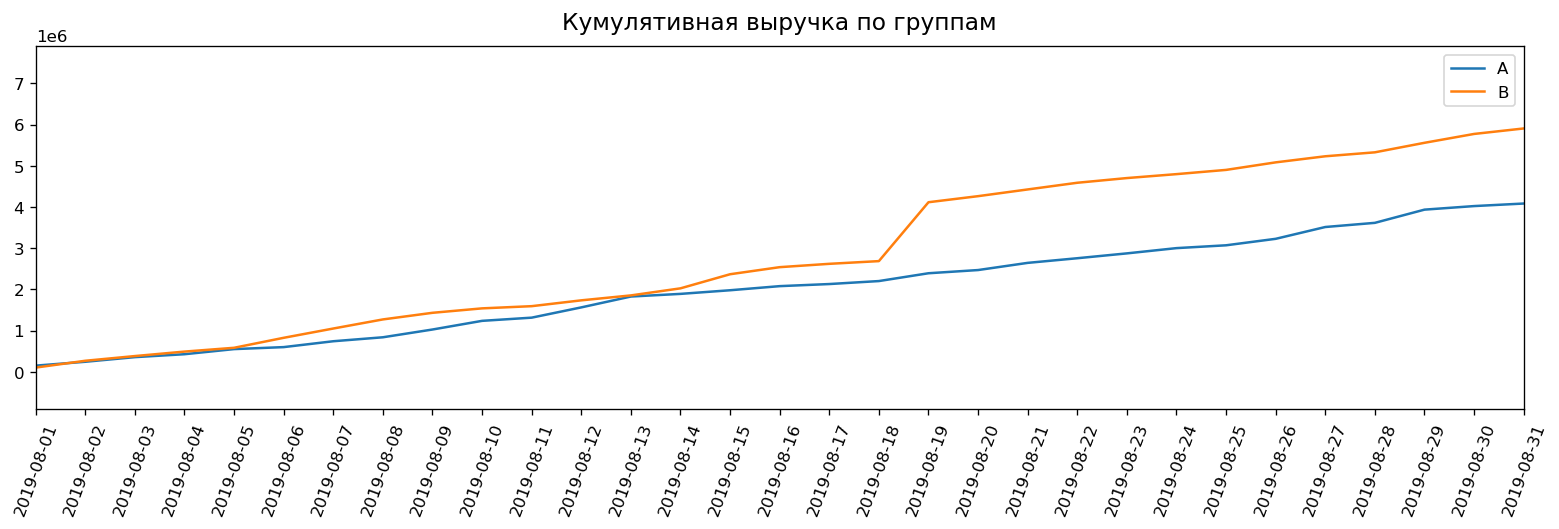

In [18]:
plt.figure(figsize=(16,4), dpi=120)

plt.plot(cummulativeDataA['date'], cummulativeDataA['revenue'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['revenue'], label='B')

plt.axis(['2019-08-01', '2019-08-31', -900000, 7900000])
plt.title('Кумулятивная выручка по группам', y=1.02, fontsize=14)
plt.xticks(rotation=70)
plt.legend()

plt.show()

К концу периода показатели стабильно растут, однако в группе B наблюдается резкий скачок 18 августа. Видимо, кто-то купил что-то очень дорогое. Нужно избавиться от подобных выбросов перед тем как делать выводы, но пока кажется, что группа B показывает лучшие результаты на протяжении практически всего теста.

## График кумулятивного среднего чека по группам.

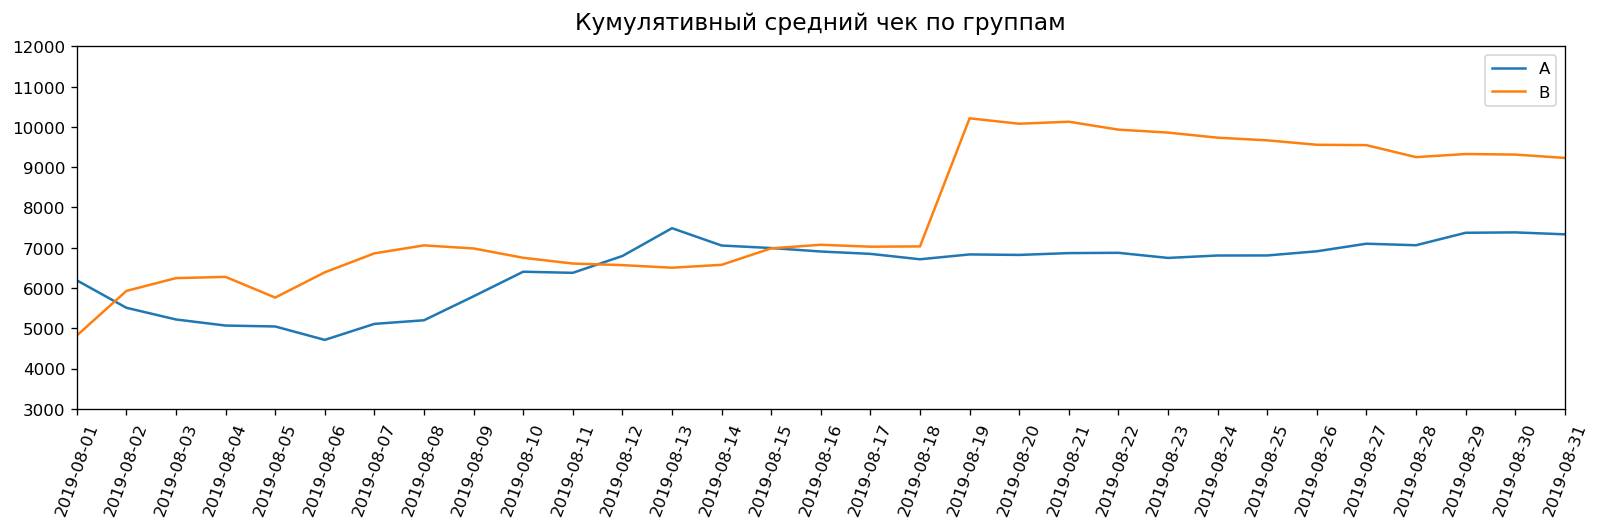

In [19]:
plt.figure(figsize=(16,4), dpi=120)

plt.plot(cummulativeDataA['date'], cummulativeDataA['revenue']/cummulativeDataA['orders'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['revenue']/cummulativeDataB['orders'], label='B')

plt.axis(['2019-08-01', '2019-08-31', 3000, 12000])
plt.title('Кумулятивный средний чек по группам', y=1.02, fontsize=14)
plt.xticks(rotation=70)
plt.legend()

plt.show()

К концу периода показатели стабилизировались, но в группе B всё так же резкий скачок 18 августа и она всё так же показывает лучшие результаты.


## График относительного изменения кумулятивного среднего чека группы B к группе A

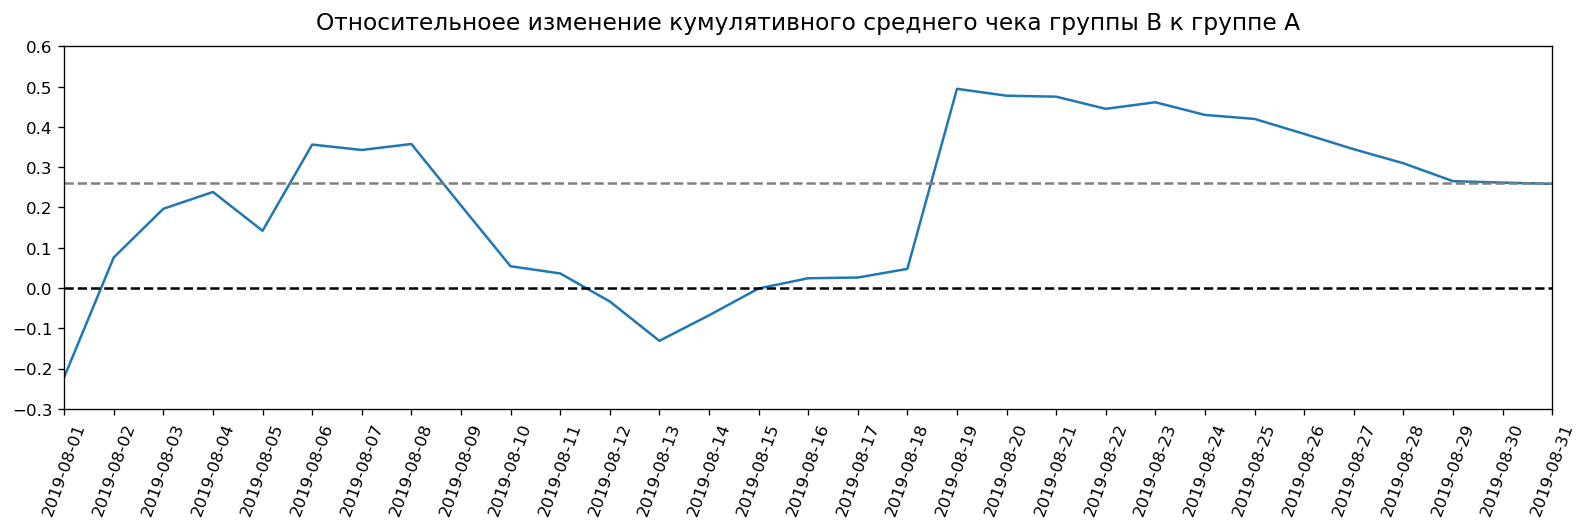

In [20]:
mergedCummulativeData = cummulativeDataA.merge(cummulativeDataB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(16,4), dpi=120)

plt.plot(mergedCummulativeData['date'], 
         (mergedCummulativeData['revenueB']/mergedCummulativeData['ordersB'])/
         (mergedCummulativeData['revenueA']/mergedCummulativeData['ordersA'])-1)

plt.axis(['2019-08-01', '2019-08-31', -0.3, 0.6])
plt.title('Относительноее изменение кумулятивного среднего чека группы B к группе А', y=1.02, fontsize=14)
plt.xticks(rotation=70)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.26, color='grey', linestyle='--')
plt.show()

Показатели неоднозначные – к концу периода средний чек был лучше примерно на 26%, но этот показатель сильно колебался в течение месяца

Проверим нулевую гипотезу "Средний чек пользователей группы B и средний чек пользователей группы A равны". Альтернативная гипотеза: "Средний чек пользователей группы В отличается от среднего чека пользователей группы В"

In [21]:
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print("P-value различия средних чеков групп A и B равно {0:.3f}".
      format(p_value))
if (p_value < .05):
    print('Отвергаем нулевую гипотезу, принимаем альтернативную\n')
else:
    print('Нет оснований отвергнуть нулевую гипотезу\n')
print("По сырым данным, относительное различие среднего чека между группами A и B – {0:.1%}".
      format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value различия средних чеков групп A и B равно 0.365
Нет оснований отвергнуть нулевую гипотезу

По сырым данным, относительное различие среднего чека между группами A и B – 25.9%


Различие между группами большое, но статистически незначимое – p-value слишком высокое – вероятность того, что разница случайна составляет 36.5%

## График кумулятивной конверсии по группам.

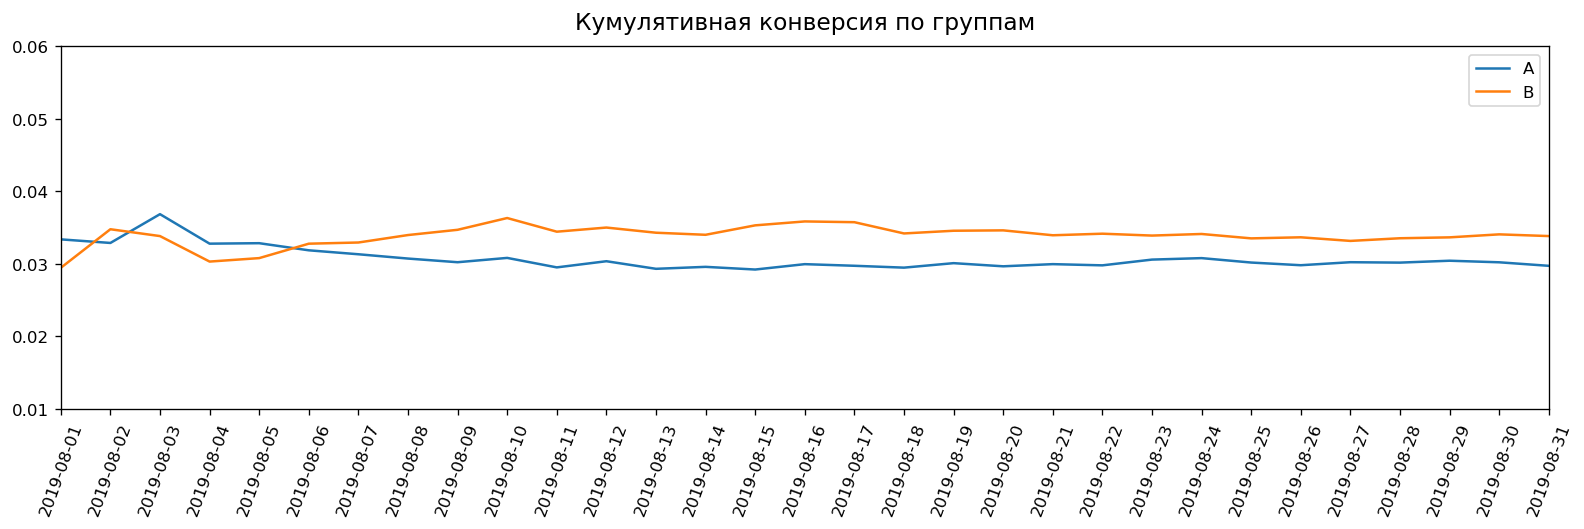

In [22]:
plt.figure(figsize=(16,4), dpi=120)

plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')

plt.axis(['2019-08-01', '2019-08-31', 0.01, 0.06])
plt.title('Кумулятивная конверсия по группам', y=1.02, fontsize=14)
plt.xticks(rotation=70)
plt.legend()

plt.show()

График конверсии выглядит более достоверным – всплесков не видно, значения стабилизировались достаточно рано. По конверсии группа В заметно лучше группы А.


## График относительного изменения кумулятивной конверсии группы B к группе A

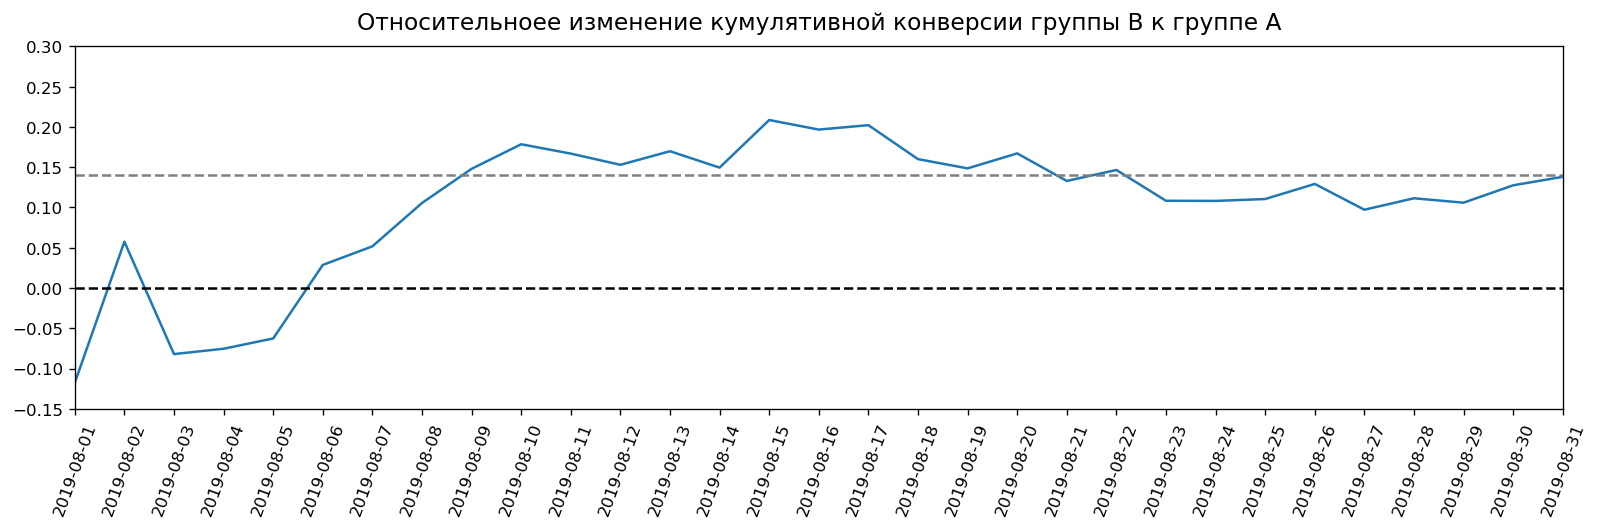

In [23]:
mergedCummulativeConversions = cummulativeDataA[['date','conversion']].merge(
    cummulativeDataB[['date','conversion']], 
    left_on='date', right_on='date', 
    how='left', suffixes=['A', 'B'])

plt.figure(figsize=(16,4), dpi=120)

plt.plot(mergedCummulativeConversions['date'], mergedCummulativeConversions['conversionB']/mergedCummulativeConversions['conversionA']-1)
plt.title('Относительноее изменение кумулятивной конверсии группы B к группе A', y=1.02, fontsize=14)

plt.axis(['2019-08-01', '2019-08-31', -0.15, 0.3])
plt.xticks(rotation=70)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')
plt.show()

Показатели конверсии пользователей группы B лучше показателей группы А примерно на 14%

Проверим нулевую гипотезу "Конверсия пользователей группы B и конверсия пользователей группы A равны". Альтернативная гипотеза: "Конверсия пользователей группы В отличается от конверсии пользователей группы В"


In [25]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - 
                                                                           len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - 
                                                                           len(ordersByUsersB['orders'])), name='orders')],axis=0)

p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
print("P-value разницы конверсий групп A и B равно {0:.5f}".format(p_value))
if (p_value < .05):
    print('Отвергаем нулевую гипотезу, принимаем альтернативную\n')
else:
    print('Нет оснований отвергнуть нулевую гипотезу\n')
print("По сырым данным, относительное различие конверсий групп A и B – {0:.1%}".format(sampleB.mean()/sampleA.mean()-1))

P-value разницы конверсий групп A и B равно 0.00840
Отвергаем нулевую гипотезу, принимаем альтернативную

По сырым данным, относительное различие конверсий групп A и B – 13.8%


Нулевую гипотезу отвергаем – конверсии групп всё же отличаются. P-value низкое – этим данным можно верить, но лучше всё же их подчистить. Пользователи группы B конвертировались на 13.8% лучше, по сравнению с пользователями группы А


## Очистка данных

### По количеству заказов

Нарисуем точечный график количества заказов по пользователям

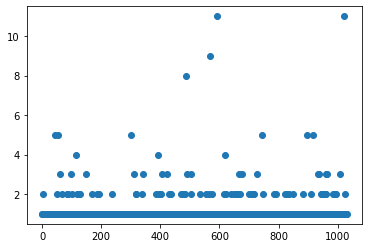

In [26]:
orders_by_users = orders.groupby('visitorId')['revenue'].count()
plt.scatter(range(0, len(orders_by_users)), orders_by_users)

In [27]:
orders_by_users.value_counts()

1     937
2      64
3      17
5       6
4       3
11      2
8       1
9       1
Name: revenue, dtype: int64

Видно, что большинство пользователей делает только один заказ и это подтверждается при вызове функции value_counts. Даже два заказа – это уже достаточно необычно, судя по графику. Чтобы сказать об этом увереннее, найдём 95-й и 99-й перцентили по количеству заказов и определим границу аномальности.

In [28]:
np.percentile(orders_by_users, [95, 99])

array([2., 4.])

Меньше 5% пользователей делали больше двух заказов и меньше 1% – больше четырёх


Условимся, что все, кто заказал больше двух раз – выбросы


In [34]:
usersWithManyOrders = pd.concat([
    ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], 
    ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']
], axis = 0)

### По стоимости заказов

Нарисуем точечный график стоимостей заказов пользователей

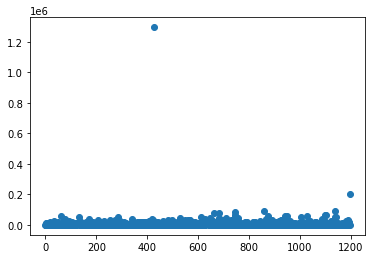

In [30]:
plt.scatter(range(0, len(orders['revenue'])), orders['revenue'])

Есть два явных аномальных значения – одно около 1 200 000 и другое около 200 000. Для того, чтобы определить границу для выбросов, обратимся к перцентилям.


In [31]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Всё, что дороже 28 000 – выброс

In [32]:
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

Запишем всех аномальных пользователей в одну переменную


In [35]:
abnormalUsers = pd.concat([
    usersWithManyOrders, 
    usersWithExpensiveOrders
], axis = 0).drop_duplicates().sort_values()

# A/B анализ по очищенным данным

Проведём тест конверсии на очищенных данных

In [36]:
conversionAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

conversionBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [37]:
print("P-value разницы конверсий групп A и B равно {0:.5f}".
      format(stats.mannwhitneyu(conversionAFiltered, conversionBFiltered)[1]))
print("По очищенным данным, относительное различие конверсий групп A и B – {0:.1%}".
      format(conversionBFiltered.mean()/conversionAFiltered.mean()-1))

P-value разницы конверсий групп A и B равно 0.00652
По очищенным данным, относительное различие конверсий групп A и B – 17.3%


После очистки данных по конверсии, группа B продемонстрировала ещё большее преимущество перед группой А, а p-value стало ещё меньше

Проведём тест выручки на очищенных данных

In [38]:
ordersFiltered = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]

ordersAFiltered = ordersFiltered[ordersFiltered['group'] == 'A']
ordersBFiltered = ordersFiltered[ordersFiltered['group'] == 'B']

In [39]:
print("P-value разницы выручек групп A и B равно {0:.3f}".format(stats.mannwhitneyu(ordersAFiltered['revenue'],ordersBFiltered['revenue'])[1]))
print("По очищенным данным, относительное различие среднего чека групп A и B – {0:.1%}".format(ordersBFiltered['revenue'].mean() / ordersAFiltered['revenue'].mean() - 1))

P-value разницы выручек групп A и B равно 0.369
По очищенным данным, относительное различие среднего чека групп A и B – -2.0%


P-value до сих пор слишком велико и статистическое различие выручки групп незначимо

# ВЫВОД

Я считаю, что тест можно остановить и зафиксировать победу группы B, так как её пользователи конвертировались в покупателей на 17.3% чаще по сравнению с пользователями группы А.

Статистически значимых различий в выручке у групп не обнаружено – они меньше 5%.

Продолжать тест нецелесообразно, так как p-value по выручке слишком велико, по конверсии – очень мало, а куммулятивные показатели групп уже стабилизировались, что видно на графиках.